<img src="../rsag_convex.png" alt="algoconvex" />
<img src="../x_update.png" alt="x_update" />
<img src="../mean.png" alt="mean" />
<img src="../rsag_composite.png" alt="algo" />

__Parameters :__
- $\alpha$: (1-$\alpha$) weight of aggregated x on current state, i.e. momentum
- $\lambda$: learning rate
- $\beta$: change for aggregated x
- $p_k$ termination probability



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import sklearn
from sklearn.neural_network import MLPClassifier

In [3]:
from sklearn.model_selection import KFold
import pandas as pd

import sys
sys.path.append('../')


# Data Loading

In [4]:
def preprocess_mnist(valid_split=0.2):
  import random as rand
  from sklearn.model_selection import train_test_split
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

  assert x_train.shape == (60000, 28, 28)
  assert x_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat

  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  # finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))

  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)

  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_split, random_state=42)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_mnist(0.2)

# Model Implementation - Softmax

### Metrics

In [5]:
def evaluate_acc(truth, pred):
  counter =0

  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter / float(len(pred))

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

### MLP

In [6]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])
linear = lambda z: np.array([i/float(sum(i)) for i in z])

def relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x
def relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

In [7]:
class MLPRelu:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None


    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params 
            q1 = np.dot(x, v1)
            z1 = relu(q1) 
            q2 = np.dot(z1, v2) 
            z2 = relu(q2)
            yh = softmax2D(np.dot(z2, w))
            acc = evaluate_acc(y. yh)

            ## Backpropagation
            dy = yh - y
            dw = np.dot(z2.T, dy)/N 
            dz2 = np.dot(dy, w.numpy().T)             
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T)               
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N 
            dparams = [dv1, dv2, dw]
            return dparams, acc

        if self.params is None:
            print('params initialized')

            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(self.M, self.num_classes))
            v2 = initializer(shape=(self.M, self.M))
            v1 = initializer(shape=(D, self.M))
            self.params = [v1, v2,w]
            if self.rsag:
                self.aggr_params = [np.copy(v1), np.copy(v2), np.copy(w)]

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, batch_train_acc

    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) 
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))
        return yh

In [8]:
class MLP_2_Layer_Softmax:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None

    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            w = params[0] # v.shape = (D, M), w.shape = (M)
            z = np.dot(x, w)
            yh = softmax2D(z)#N
            dy = yh - y #N
            train_acc = evaluate_acc(y, yh)

            # Softmax Gradient
            dw = np.dot(x.T, dy)/N #M
            dparams = [dw]
            return dparams, train_acc
        
        if self.params is None:
            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(D, self.num_classes))
            self.params = [w]
            if self.rsag:
                self.aggr_params = [np.copy(w)]
            print('params initialized')

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, train_accs, batch_train_acc

    def predict(self, x):
        
        w = self.params[0]
        yh = softmax2D(np.dot(x, w))#N
        return yh

# RSAG

In [9]:
lr_lamda = lambda lr, t: lr/(1+t)

In [10]:
def train_model(model, 
                optimizer, 
                x_train, 
                y_train, 
                x_valid, 
                y_valid, 
                verbose=True, 
                print_every=10, 
                patience=20,
                save_log=False):

    log = {'loss': [], 'accuracy': [], 'v_loss': [], 'v_accuracy': [], 'time': []}
    t=0
    log['time'].append(time.time())
    curr_patience = 0
    accept_update = (optimizer.lr_fn is not None) or (optimizer.alpha_fn is not None) or (optimizer.beta_fn is not None)


    while t < optimizer.max_iters:
        
        model.fit(x_train, y_train, optimizer)

        log['accuracy'].append(evaluate_acc(y_train, model.predict(x_train)))
        log['loss'].append(log_loss(y_train, model.predict(x_train)))

        y_valid_pred = model.predict(x_valid)
        temp_v_acc = evaluate_acc(y_valid, y_valid_pred)
        log['v_accuracy'].append(temp_v_acc)
        log['v_loss'].append(log_loss(y_valid, y_valid_pred))
        
        if verbose:
            if t%print_every == 0:
                print('Epoch {}/{}'.format(t, optimizer.max_iters))
                print('-' * 10)
                print('Loss {:.4f}'.format(log['loss'][-1]))
                print('Accuracy:  {:.4f}'.format(log['accuracy'][-1]))
                print('Validation Loss {:.4f}'.format(log['v_loss'][-1]))
                print('Validation Accuracy:  {:.4f}'.format(log['v_accuracy'][-1]))
                print('Time :', log['time'][-1]-log['time'][0])
        
        log['time'].append(time.time())

        if len(log['v_accuracy']) > 1 and (np.abs(log['v_accuracy'][-1]-log['v_accuracy'][-2])<0.001):
            curr_patience += 1
            if curr_patience > patience:
                if accept_update:
                    print()
                    optimizer.set_update_params(True)
                    curr_patience = 0
                else:
                    print('Early stopping at epoch %d'%t)
                    break
        else:
            curr_patience = 0
        t+=1
    if verbose:
        print(log)
    # if save_log == True:
    #     np.save('log.csv', log)
    return model, log, max(log['v_accuracy'])

In [23]:
class RSAG:

    def __init__(self, 
                 learning_rate=.001, 
                 alpha=0.009, 
                 beta=.000009, 
                 max_iters=50, 
                 epsilon=1e-8, 
                 batch_size=64,
                 lr_fn = None,
                    alpha_fn = None,
                    beta_fn = None,
                    start_adap = 30,
                 ):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.alpha = alpha  # momentum param
        self.beta = beta 

        self.lr_fn = lr_fn
        self.alpha_fn = alpha_fn
        self.beta_fn = beta_fn

        self.update_params = False

        self.t = 0


    def set_update_params(self, update_params):
        self.update_params = update_params

    def mini_batch_step(self, 
                       gradient_fn,
                       x, 
                       y,
                       params, 
                       agg_params,
                       ):
        
        train_acc, batch_train_acc, chunk = [], [], []


        slices = sklearn.utils.gen_batches(x.shape[0], self.batch_size)


        if self.update_params:
            print('Update params')
            if self.lr_fn is not None:
                self.learning_rate = self.lr_fn(self.learning_rate, self.t)
                # print('New learning rate:', self.learning_rate)
            if self.alpha_fn is not None:
                self.alpha = self.alpha_fn(self.alpha, self.t)
                # print('New alpha:', self.alpha)
            if self.beta_fn is not None:
                self.beta = self.beta_fn(self.beta, self.t)
                # print('New beta:', self.beta)
            self.update_params = False

        grad = None
        for batch in slices:
            x_temp, y_temp = x[batch], y[batch]

            proj_params = [(1-self.alpha) * a_p + self.alpha * p for p, a_p in zip(params, agg_params)]

            grad, temp_acc = gradient_fn(x_temp, y_temp, proj_params)

            chunk.append(temp_acc)
            train_acc.append( ( self.t, temp_acc ) )

            for p in range(len(params)):
                agg_params[p] -= self.beta * (grad[p])
                params[p] -= self.learning_rate * (grad[p])

            
        self.t += 1
            
        return params, agg_params, train_acc, batch_train_acc

## Constant Learning Rate

In [20]:
adam_clf = MLPClassifier(hidden_layer_sizes=(512,512,), activation='relu', solver='adam', alpha=0.01, batch_size=64, learning_rate='constant', learning_rate_init=0.0001,verbose=True)
%time adam_clf.fit(x_train, y_train)
print(adam_clf.loss_curve_)

Iteration 1, loss = 1.16891027
Iteration 2, loss = 0.45429807
Iteration 3, loss = 0.35346403
Iteration 4, loss = 0.29678101
Iteration 5, loss = 0.25831693
Iteration 6, loss = 0.22953918
Iteration 7, loss = 0.20654358
Iteration 8, loss = 0.18754256
Iteration 9, loss = 0.17211101
Iteration 10, loss = 0.15884244
Iteration 11, loss = 0.14714980
Iteration 12, loss = 0.13727282
Iteration 13, loss = 0.12853608
Iteration 14, loss = 0.12060858
Iteration 15, loss = 0.11384973
Iteration 16, loss = 0.10819632
Iteration 17, loss = 0.10298384
Iteration 18, loss = 0.09824272
Iteration 19, loss = 0.09370092
Iteration 20, loss = 0.08996117
Iteration 21, loss = 0.08658200
Iteration 22, loss = 0.08342595
Iteration 23, loss = 0.08004248
Iteration 24, loss = 0.07797553
Iteration 25, loss = 0.07500910
Iteration 26, loss = 0.07207928
Iteration 27, loss = 0.07039842
Iteration 28, loss = 0.06840428
Iteration 29, loss = 0.06617001
Iteration 30, loss = 0.06429029
Iteration 31, loss = 0.06263949
Iteration 32, los

In [19]:
n_clf = MLPClassifier(hidden_layer_sizes=(512,512,), activation='relu', solver='sgd', alpha=0.0001, momentum=0.009, batch_size=64, learning_rate='constant', learning_rate_init=0.09, nesterovs_momentum=True,verbose=True)
%time n_clf.fit(x_train, y_train)
print(n_clf.loss_curve_)

Iteration 1, loss = 0.63789124
Iteration 2, loss = 0.26656644
Iteration 3, loss = 0.18863134
Iteration 4, loss = 0.14357443
Iteration 5, loss = 0.11106193
Iteration 6, loss = 0.08913288
Iteration 7, loss = 0.07102716
Iteration 8, loss = 0.05664972
Iteration 9, loss = 0.04564722
Iteration 10, loss = 0.03653021
Iteration 11, loss = 0.02948668
Iteration 12, loss = 0.02384751
Iteration 13, loss = 0.01986132
Iteration 14, loss = 0.01625092
Iteration 15, loss = 0.01377142
Iteration 16, loss = 0.01188446
Iteration 17, loss = 0.01012025
Iteration 18, loss = 0.00903823
Iteration 19, loss = 0.00802422
Iteration 20, loss = 0.00722573
Iteration 21, loss = 0.00653646
Iteration 22, loss = 0.00606082
Iteration 23, loss = 0.00557325
Iteration 24, loss = 0.00521912
Iteration 25, loss = 0.00488162
Iteration 26, loss = 0.00462655
Iteration 27, loss = 0.00434829
Iteration 28, loss = 0.00416958
Iteration 29, loss = 0.00396049
Iteration 30, loss = 0.00378662
Iteration 31, loss = 0.00366361
Iteration 32, los

In [18]:
model = MLPRelu(M=512, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.009)
model, log, acc_max = train_model(model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/2000
----------
Loss 2.2756
Accuracy:  0.1826
Validation Loss 2.2755
Validation Accuracy:  0.1820
Time : 0.0
Epoch 10/2000
----------
Loss 1.7454
Accuracy:  0.6201
Validation Loss 1.7486
Validation Accuracy:  0.6175
Time : 350.2959864139557
Epoch 20/2000
----------
Loss 1.3604
Accuracy:  0.6947
Validation Loss 1.3651
Validation Accuracy:  0.6907
Time : 697.0579235553741
Epoch 30/2000
----------
Loss 1.1022
Accuracy:  0.7142
Validation Loss 1.1075
Validation Accuracy:  0.7094
Time : 1045.955016374588
Epoch 40/2000
----------
Loss 0.9503
Accuracy:  0.7175
Validation Loss 0.9561
Validation Accuracy:  0.7129
Time : 1402.3753640651703
Epoch 50/2000
----------
Loss 0.8856
Accuracy:  0.7150
Validation Loss 0.8925
Validation Accuracy:  0.7116
Time : 1759.0163478851318
Early stopping at epoch 52
{'loss': [2.2756220825377422, 2.215833607752279, 2.157534256320828, 2.100734579749943, 2.045450837376454, 1.9916754010768885, 1.939414862114453, 1.8886644718379053, 1.83941590

## Adaptive Rates

In [21]:
from sklearn.neural_network import MLPClassifier
ada_adam_clf = MLPClassifier(hidden_layer_sizes=(512,512,), 
                    activation='relu', 
                    solver='adam', 
                    alpha=0.0001, 
                    batch_size=64, 
                    learning_rate='adaptive', learning_rate_init=0.01, 
                    verbose=True)
%time ada_adam_clf.fit(x_train, y_train)
print(ada_adam_clf.loss_curve_)

Iteration 1, loss = 0.51707414
Iteration 2, loss = 0.35093219
Iteration 3, loss = 0.28363141
Iteration 4, loss = 0.26724972
Iteration 5, loss = 0.26051277
Iteration 6, loss = 0.24003818
Iteration 7, loss = 0.25203335
Iteration 8, loss = 0.24106282
Iteration 9, loss = 0.24802173
Iteration 10, loss = 0.25447979
Iteration 11, loss = 0.24005500
Iteration 12, loss = 0.25516404
Iteration 13, loss = 0.25635597
Iteration 14, loss = 0.26322627
Iteration 15, loss = 0.24000582
Iteration 16, loss = 0.23691416
Iteration 17, loss = 0.26099829
Iteration 18, loss = 0.24297283
Iteration 19, loss = 0.23675805
Iteration 20, loss = 0.24873758
Iteration 21, loss = 0.25243657
Iteration 22, loss = 0.23771994
Iteration 23, loss = 0.25517576
Iteration 24, loss = 0.25281627
Iteration 25, loss = 0.25430582
Iteration 26, loss = 0.24616455
Iteration 27, loss = 0.25558899
Iteration 28, loss = 0.23203635
Iteration 29, loss = 0.22858730
Iteration 30, loss = 0.24794025
Iteration 31, loss = 0.26663126
Iteration 32, los

In [29]:
from sklearn.neural_network import MLPClassifier
ada_n_clf = MLPClassifier(hidden_layer_sizes=(512,512,), 
                    activation='relu', 
                    solver='sgd', 
                    nesterovs_momentum=True, momentum=0.8, 
                    alpha=0.0001, 
                    batch_size=64, 
                    learning_rate='adaptive', learning_rate_init=0.09, 
                    verbose=True)
%time ada_n_clf.fit(x_train, y_train)
print(ada_n_clf.loss_curve_)

Iteration 1, loss = 0.38144614
Iteration 2, loss = 0.14109886
Iteration 3, loss = 0.08691484
Iteration 4, loss = 0.05445906
Iteration 5, loss = 0.03573667
Iteration 6, loss = 0.01936130
Iteration 7, loss = 0.01125849
Iteration 8, loss = 0.00537069
Iteration 9, loss = 0.00351385
Iteration 10, loss = 0.00275126
Iteration 11, loss = 0.00242062
Iteration 12, loss = 0.00227254
Iteration 13, loss = 0.00214402
Iteration 14, loss = 0.00207973
Iteration 15, loss = 0.00202640
Iteration 16, loss = 0.00198765
Iteration 17, loss = 0.00195589
Iteration 18, loss = 0.00192932
Iteration 19, loss = 0.00190399
Iteration 20, loss = 0.00188356
Iteration 21, loss = 0.00186609
Iteration 22, loss = 0.00184962
Iteration 23, loss = 0.00183730
Iteration 24, loss = 0.00182417
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.018000
Iteration 25, loss = 0.00180706
Iteration 26, loss = 0.00180452
Iteration 27, loss = 0.00180232
Iteration 28, loss = 0.00180049

In [31]:
ada_model = MLPRelu(M=512, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.009,
                lr_fn=lr_lamda, alpha_fn=lr_lamda, beta_fn=lr_lamda, 
                start_adap=49)
ada_model, ada_log, acc_max = train_model(ada_model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/50
----------
Loss 2.2580
Accuracy:  0.1883
Validation Loss 2.2582
Validation Accuracy:  0.1892
Time : 0.0
Epoch 10/50
----------
Loss 1.6687
Accuracy:  0.6744
Validation Loss 1.6718
Validation Accuracy:  0.6729
Time : 299.3806703090668
Epoch 20/50
----------
Loss 1.2728
Accuracy:  0.7126
Validation Loss 1.2759
Validation Accuracy:  0.7125
Time : 579.4678339958191
Epoch 30/50
----------
Loss 1.0384
Accuracy:  0.7181
Validation Loss 1.0405
Validation Accuracy:  0.7180
Time : 860.206104516983
Epoch 40/50
----------
Loss 0.9286
Accuracy:  0.7141
Validation Loss 0.9301
Validation Accuracy:  0.7163
Time : 1141.6902871131897
{'loss': [2.258039045878575, 2.1899672279928044, 2.123927876184631, 2.0599354345611247, 1.9979906310708833, 1.9380854358089845, 1.880205731331355, 1.8243473056677066, 1.7704955905721758, 1.7186351106223725, 1.6687498258446394, 1.6208222299764425, 1.5748343427250657, 1.5307522640123488, 1.4885434519719756, 1.4481812626709671, 1.4096319910603998,

In [27]:
print('Adam: ', accuracy_score(y_test, adam_clf.predict(x_test)))
print('Nesterov\'s Momentum: ', accuracy_score(y_test, n_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, model.predict(x_test)))

Adam:  0.9705
Nesterov's Momentum:  0.9684
RSAG:  0.7248


In [33]:
print('Adam: ', accuracy_score(y_test, ada_adam_clf.predict(x_test)))
print('Nesterov\'s Momentum: ', accuracy_score(y_test, ada_n_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, ada_model.predict(x_test)))

Adam:  0.957
Nesterov's Momentum:  0.9756
RSAG:  0.7194


In [34]:
adam_avg_epoch_time = (91*60+8)/128
n_avg_epoch_time = (30*60+36)/46
rsag_avg_epoch_time = (43*60+3)/52 # rerun with time

ada_adam_avg_epoch_time = (109*60+44)/60
ada_n_avg_epoch_time = (71*60+18)/112
ada_rsag_avg_epoch_time = (42*60+48)/50
print('Adam', adam_avg_epoch_time)
print('N ', n_avg_epoch_time)
print('RSAG', rsag_avg_epoch_time)
print('Adam', ada_adam_avg_epoch_time)
print('N ', ada_n_avg_epoch_time)
print('RSAG', ada_rsag_avg_epoch_time)

Adam 42.71875
N  39.91304347826087
RSAG 49.67307692307692
Adam 109.73333333333333
N  38.19642857142857
RSAG 51.36


In [35]:
losses = [adam_clf.loss_curve_, n_clf.loss_curve_, log['v_loss'], ada_adam_clf.loss_curve_,ada_n_clf.loss_curve_, ada_log['v_loss']]
epoch_time = [adam_avg_epoch_time, n_avg_epoch_time, rsag_avg_epoch_time, ada_adam_avg_epoch_time, ada_n_avg_epoch_time, ada_rsag_avg_epoch_time]

times = []
for t, l in zip(epoch_time, losses):
    times.append([t*i for i in range(len(l))])



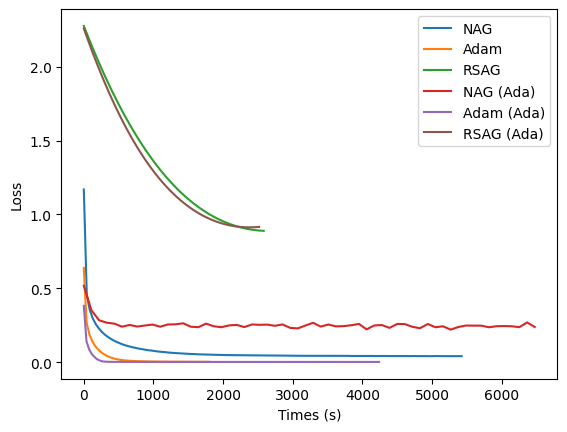

In [36]:
def plot_adjusted_loss(logs, y, labels):
    for log, t, label in zip(logs,y,labels):
        plt.plot(t, log, label=label)
        plt.xlabel('Times (s)')
        plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_adjusted_loss(losses, times,['NAG', 'Adam', 'RSAG', 'NAG (Ada)', 'Adam (Ada)', 'RSAG (Ada)'])

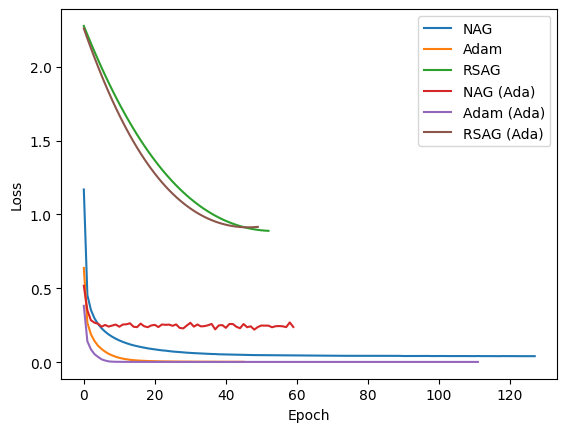

In [39]:
plot_losses([adam_clf.loss_curve_, n_clf.loss_curve_, log['v_loss'], ada_adam_clf.loss_curve_,ada_n_clf.loss_curve_, ada_log['v_loss']], ['NAG', 'Adam', 'RSAG', 'NAG (Ada)', 'Adam (Ada)', 'RSAG (Ada)'])

# Plots

In [38]:
def plot_losses(logs, labels):
    for log, label in zip(logs,labels):
        plt.plot(range(len(log)), log, label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracies_vs_time(logs):
    for log in logs:
        plt.plot(log['v_accuracy'], log['time'], label=log['label'])
        plt.xlabel('Time (s)')
        plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

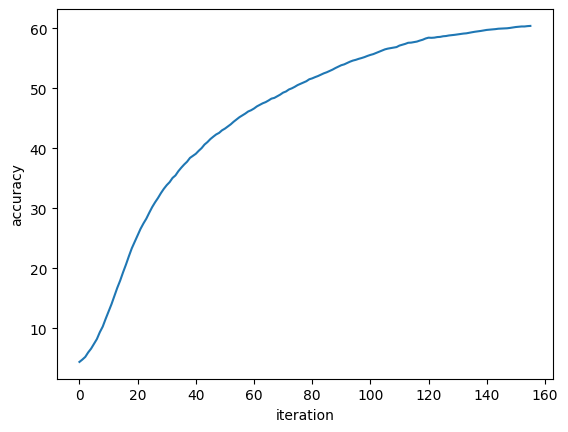

In [41]:
plot_accuracies(log['v_accuracy'])

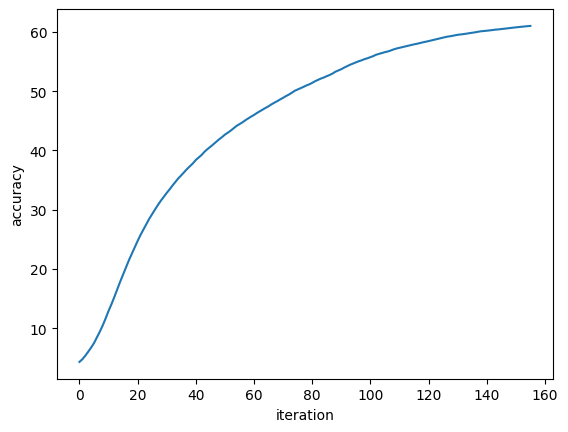

In [42]:
plot_accuracies(log['accuracy'])

In [245]:
def hyper_tuning(x_train, y_train, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  momentum = [0.9, 0.99, 0.75, 0.5]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      for mom in momentum:
        print('--------New Model----------')
        print(f"learning rate: {lr}\t Batch Size:{btch}\t Momentum:{mom}")

        optimizer = GradientDescent(learning_rate = lr, batch_size=btch, momentum=mom, lr_lamda=lr_fn)
        
        avg_acc = 0;       
        # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
        start = time.time()
        for k, (train, test) in enumerate(kf.split(x_train, y_train)):
            print('k:',k)
            temp_model = MLP(M=128)
            temp_model, log, temp_acc = train_model(temp_model, optimizer, x_train[train], y_train[train])
            avg_acc += temp_acc
        avg_acc = avg_acc/5
        acc_vals.append(avg_acc)
        end = time.time()
        print('time elapsed:',(end-start)/60/60,"hrs")
        print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [246]:
def hyper_tuning_gd(x_train, y_train, print_every=100, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      
      
      print('--------New Model----------')
      print(f"learning rate: {lr}\t Batch Size:{btch}")

      optimizer = GradientDescent(learning_rate = lr, batch_size=btch, lr_fn=lr_fn)
      
      avg_acc = 0;       
      # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
      start = time.time()
      for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
          print('k:',k)
          temp_model = MLP(M=128)
          temp_model, log, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], print_every=print_every)
          avg_acc += max_acc
      avg_acc = avg_acc/5
      acc_vals.append(avg_acc)
      end = time.time()
      print('time elapsed:',(end-start)/60/60,"hrs")
      print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [248]:
hyper_tuning_gd(x_train=x_train[:10000], y_train=y_train[:10000], print_every=10)


batchsize: 16
--------New Model----------
learning rate: 0.001	 Batch Size:16
k: 0
params initialized
acc: 9.6
Epoch 0: 9.6%
Epoch 100: 9.65%
Epoch 200: 9.65%
Epoch 300: 9.65%


KeyboardInterrupt: 

In [ ]:
def hyper_tuning_rsag(x_train, 
                      y_train ,
                      x_valid=None,
                      y_valid=None,
                      adaptive=False,
                      convex=False,
                      ):

  nb_folds = 5
  kf = KFold(nb_folds)
  acc_vals = []

  # learning_rate = [0.3, 0.09, 0.01]
  learning_rate = [0.005, 0.009, 0.001]
  alphas = [.9, .09, .009, .0009]
  betas = [.09, .009, 0.00009]
  
  for alpha in alphas:
    print('alpha:',alpha)
    for beta in betas:
        for lr in learning_rate:
            print('--------New Model----------')
            print(f"learning rate: {lr}\t alpha: {alpha}\t beta:{beta}")
            if adaptive:
                optimizer = RSAG(learning_rate = lr, 
                                 alpha=alpha, 
                                 beta=beta, 
                                 batch_size=64, 
                                 lr_fn=lr_lamda,
                                 alpha_fn=lr_lamda,
                                 beta_fn=lr_lamda)
            else:
              optimizer = RSAG(learning_rate = lr, alpha=alpha, beta=beta, batch_size=64)

            avg_acc = 0;       
            start = time.time()
            for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
                print('k:',k)

                if convex:
                  temp_model = MLP_1_Layer_Linear(M=128, num_classes=10, rsag=True)
                else:
                  temp_model = MLPRelu(M=512, num_classes=10, rsag=True)

                temp_model, temp_accs, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], verbose=False)
                print(f'Fold {k} max acc: {max_acc}')
                avg_acc += max_acc
            
            avg_acc = avg_acc/nb_folds
            acc_vals.append(avg_acc)
            end = time.time()
            print('time elapsed:',(end-start)/60/60,"hrs")
            print('acc:',avg_acc)
            
  data = {'learningRate' : (([0.3]*len(betas))*len(alphas)).append(([0.09]*len(betas))*len(alphas)).append(([0.01]*len(betas))*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)),
          'alpha':[.9]*len(betas).append([.09]*len(betas)).append([.009]*len(betas)).append([.0009]*len(betas))*len(learning_rate),
          'beta':[.001, .002, 0.004]*len(alphas)*len(learning_rate),
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [ ]:
hyper_tuning_rsag(x_train=x_train[:2000], y_train=y_train[:2000], adaptive=True) 

In [ ]:
hyper_tuning_rsag(x_train=x_train[:2000], y_train=y_train[:2000], adaptive=False) 

alpha: 0.9
--------New Model----------
learning rate: 0.005	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.5575
k: 1
params initialized
Fold 1 max acc: 0.58
k: 2
params initialized
Fold 2 max acc: 0.6225
k: 3
params initialized
Fold 3 max acc: 0.535
k: 4
params initialized
Fold 4 max acc: 0.6625
time elapsed: 0.026808643407291836 hrs
acc: 0.5915
--------New Model----------
learning rate: 0.009	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.7275
k: 1
params initialized
Fold 1 max acc: 0.695
k: 2
params initialized
Fold 2 max acc: 0.7025
k: 3
params initialized
Fold 3 max acc: 0.705
k: 4
params initialized
Fold 4 max acc: 0.7725
time elapsed: 0.028314995235866967 hrs
acc: 0.7205
--------New Model----------
learning rate: 0.001	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.2025
k: 1
params initialized
Early stopping at epoch 155
Fold 1 max acc: 0.125
k: 2
params initialized
Fold 2 max acc: 0.1775
k: 3
params initialized
Fold 3 max acc

AttributeError: 'NoneType' object has no attribute 'append'